# Load data

In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file
from tqdm import tqdm

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data("../data/Bibtex_data.txt")
print(X.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


# Own- AdaptiveGreedy

- Adaptive greedy with threshold (as opposed to percentile) and beta prior (as opposed to smoothing).

SUMMARY

fit()
1) The fit method fits a model individually based upon the rewards we observed for each bandit in the batch (batch = 50 rows).
- So if we decided to play Bandit 1, for say rounds 3, 40, 55, we would fit a model on the context we had for those three rounds
    with the rewards we observed (which can be 0 or 1).
- SPECIAL SITUATION 1) There is a potential problem though if we observe only rewards 0 or only rewards 1, we really cannot fit a model on examples with 
  only one label. In these situations we will predict a 0 or 1 automatically.
- SPECIAL SITUATION 2) Furthermore, for cases where we have less than 2 positive or 2 negative for each bandit, we will use a beta prior and
draw the label from a beta distribution as per the paper.

2) So in summary, at the start of every fit(), we first make a list containing unfit logistic regression models. We then overwrite these models with the beta prior above if the conditions hold. We then proceed to fit the models on the historical data (which increases over time). Over time, as we have more samples for each bandit, we will have less overwriting and end up using the logistic regression more and more for predicitons.

Predict()
1) The predict method loops through all the models and predicts a probability. It then takes the argmax probability over all bandits and compares it to the threshold. If it is below the threshold, it takes a random bandit (hence exploring). If it is greater, it chooses the bandit with the highest probability as the action and the reward is revealed (0 or 1).

2) This threshold is then decayed after the end of every batch making it smaller which means the probability of choosing randomly becomes smaller (hence less exploration).

Other things
1) In addition to beta priors, it is possible to do smoothing. r_smooth = (r * n + a) / (n + b) which is number of positives over total number per bandit.

Extension
1) The extension adds weighting to the bandit fitting process. This means that examples further away in history will be weighted less (say 0.7 for a row vs 0.9 for a more recennt row). The intuition is that the policy is worse earlier (due to more exploraration) but as time progresses it becomes better so when we do a full-refit we may want to discount the early actions more.
2) New base learner. The original paper used logistic regression and we try several other ones such as random forest.

In [2]:
class BetaPredictor():
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def fit(self, X=None, y=None, sample_weight=None):
        pass
    
    def predict_proba(self, X):
        preds = np.random.beta(self.a, self.b, size = X.shape[0]).reshape((-1, 1))
        return np.c_[1.0 - preds, preds]

    def decision_function(self, X):
        return np.random.beta(self.a, self.b, size = X.shape[0])

    def predict(self, X):
        return (np.random.beta(self.a, self.b, size = X.shape[0])).astype('uint8')

In [3]:
def discount_func(x, a = 0.1):
    return x / (x + a)

In [4]:
class adaptive_greedy():
    """
    Args
        model: [Sklearn linear model] .Implements fit/predict
        num_bandits: [int] Number of bandits/classes we choose from.
        beta_prior: [tuple]. First element refers to alpha and beta for smoothing. Second element is number of positive/
                                    negative labels we need to see for each bandit before we stop using the beta-prior                      
        smoothing: [tuple]. First element is alpha in smoothing and second beta in smooting.
                                r_smooth = (r * n + a) / (n + b) which is number of positives over total number per bandit.
        decay: [float]. We can decay the threshold after a certain number of rounds
    """
    def __init__(self, model, num_bandits, beta_prior, smoothing = None, decay = 0.9998, discount_rate = None):
        
        self.num_bandits = num_bandits
        self.beta_prior = beta_prior                     #((3,7),2) used in paper
        self.base_model = model
        self.threshold = 1.0 / (np.sqrt(nchoices) * 2.0)  # 1 / (2* sqrt(k)) used in paper
        self.decay = decay
        self.bandit_counter = np.zeros((3, num_bandits)) #[indicator whether to use Beta prior, num pos, num neg] per class
        self.smoothing = smoothing
        if self.smoothing is not None:
            self.counters = np.zeros((1, n)) #where n counts the number of observations per class
        else:
            self.counters = None
        if discount_rate is not None:
            self.bandit_weights = [np.array([]) for _ in range(self.num_bandits)]
            self.discount_rate = discount_rate
        else:
            self.discount_rate = None
            
        self.num_rounds = 0

    def fit(self, X, a, r):
        self.algos = [deepcopy(self.base_model) for i in range(self.num_bandits)]
        self.num_rounds += 1
        for i in range(self.num_bandits):
            self.fit_base_model(X, a, r, i)
            
    def update_bandit_weights(self, X, bandit):
        discount_rate = discount_func(self.num_rounds) #get discount rate dynamically.
        prior_nob = len(self.bandit_weights[bandit])
        if prior_nob < 1:
            new_weights = np.ones((X.shape[0], 1))
            self.bandit_weights[bandit] = new_weights
        else:
            new_weights = np.zeros((X.shape[0], 1))
            new_weights[:prior_nob] = self.bandit_weights[bandit] * discount_rate 
            new_weights[prior_nob:] = 1                                                
            self.bandit_weights[bandit] = new_weights
            
    def fit_base_model(self, X, a, r, bandit):
        a_for_bandit = (a == bandit)
        y_for_bandit =  r[a_for_bandit]
        num_pos = y_for_bandit.sum()
        
        if self.smoothing is not None:
            self.counters[0, i] += y_for_bandit.shape[0]
        if (num_pos < self.beta_prior[1]) or ((y_for_bandit.shape[0] - num_pos) < self.beta_prior[1]):
                self.algos[bandit] = BetaPredictor(self.beta_prior[0][0] + num_pos,self.beta_prior[0][1] + y_for_bandit.shape[0] - num_pos)
                return None
        xclass = X[a_for_bandit, :]
        if self.discount_rate is not None:
            self.update_bandit_weights(xclass, bandit)
            self.algos[bandit].fit(xclass, y_for_bandit, self.bandit_weights[bandit].flatten())
        else:
            self.algos[bandit].fit(xclass, y_for_bandit)
        
        if self.beta_prior[1] > 0:
            self.increase_bandit_counter(y_for_bandit, bandit)
            
    def increase_bandit_counter(self, y_for_bandit, bandit):
        if (self.bandit_counter[0, bandit] == 0):
            n_pos = y_for_bandit.sum()
            self.bandit_counter[1, bandit] += n_pos
            self.bandit_counter[2, bandit] += y_for_bandit.shape[0] - n_pos
            if (self.bandit_counter[1, bandit] > beta_prior[1]) and (self.bandit_counter[2, bandit] > beta_prior[1]):
                self.bandit_counter[0, bandit] = 1
        
    def predict(self, X):
        pred = self._predict(X)
        self.threshold *= self.decay ** X.shape[0]
        return pred
    
    def _predict(self, X):
        preds_proba = np.zeros((X.shape[0], self.num_bandits))
        for bandit in range(self.num_bandits):
            preds_proba[:, bandit] = self.algos[bandit].predict_proba(X)[:, 1]

        if (self.smoothing is not None) and (self.counters is not None):
            preds_proba[:, :] = (preds_proba * self.counters + smoothing[0]) / (self.counters + smoothing[1])

        pred_max = preds_proba.max(axis = 1)
        pred = np.argmax(preds_proba, axis = 1)
        below_thr = pred_max <= self.threshold
        if np.any(below_thr):
            pred[below_thr] = np.random.randint(self.num_bandits, size = below_thr.sum())
            
        return pred

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from contextualbandits.online import AdaptiveGreedy
from copy import deepcopy

nchoices = y.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
base_algorithm2 = RandomForestClassifier(n_estimators=100, random_state=0)
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use this prior

adaptive_greedy1 = adaptive_greedy(deepcopy(base_algorithm), nchoices , beta_prior)
adaptive_greedy_disc = adaptive_greedy(deepcopy(base_algorithm), nchoices , beta_prior, discount_rate = True)
adaptive_greedy_rf = adaptive_greedy(deepcopy(base_algorithm2), nchoices , beta_prior, discount_rate = True)

# Original Adaptive Greedy

In [6]:
#adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
#                                     decay_type='threshold',
#                                     beta_prior = beta_prior)

# Comparison

In [7]:
models = [adaptive_greedy1, adaptive_greedy_disc, adaptive_greedy_rf]

In [8]:
# These lists will keep track of the rewards obtained by each policy
rewards_agr, rewards_agr2, rewards_agr3 = [list() for i in range(len(models))]

lst_rewards = [rewards_agr, rewards_agr2, rewards_agr3]

# batch size - algorithms will be refit after N rounds
batch_size = 50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_agr, lst_a_agr2, lst_a_agr3 = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_agr, lst_a_agr2, lst_a_agr3]

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist])
    
    return new_actions_hist

# now running all the simulation
for i in tqdm(range(int(np.floor(X.shape[0] / batch_size)))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X, y,
                                             batch_st, batch_end)

100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [03:38<00:00,  1.49s/it]


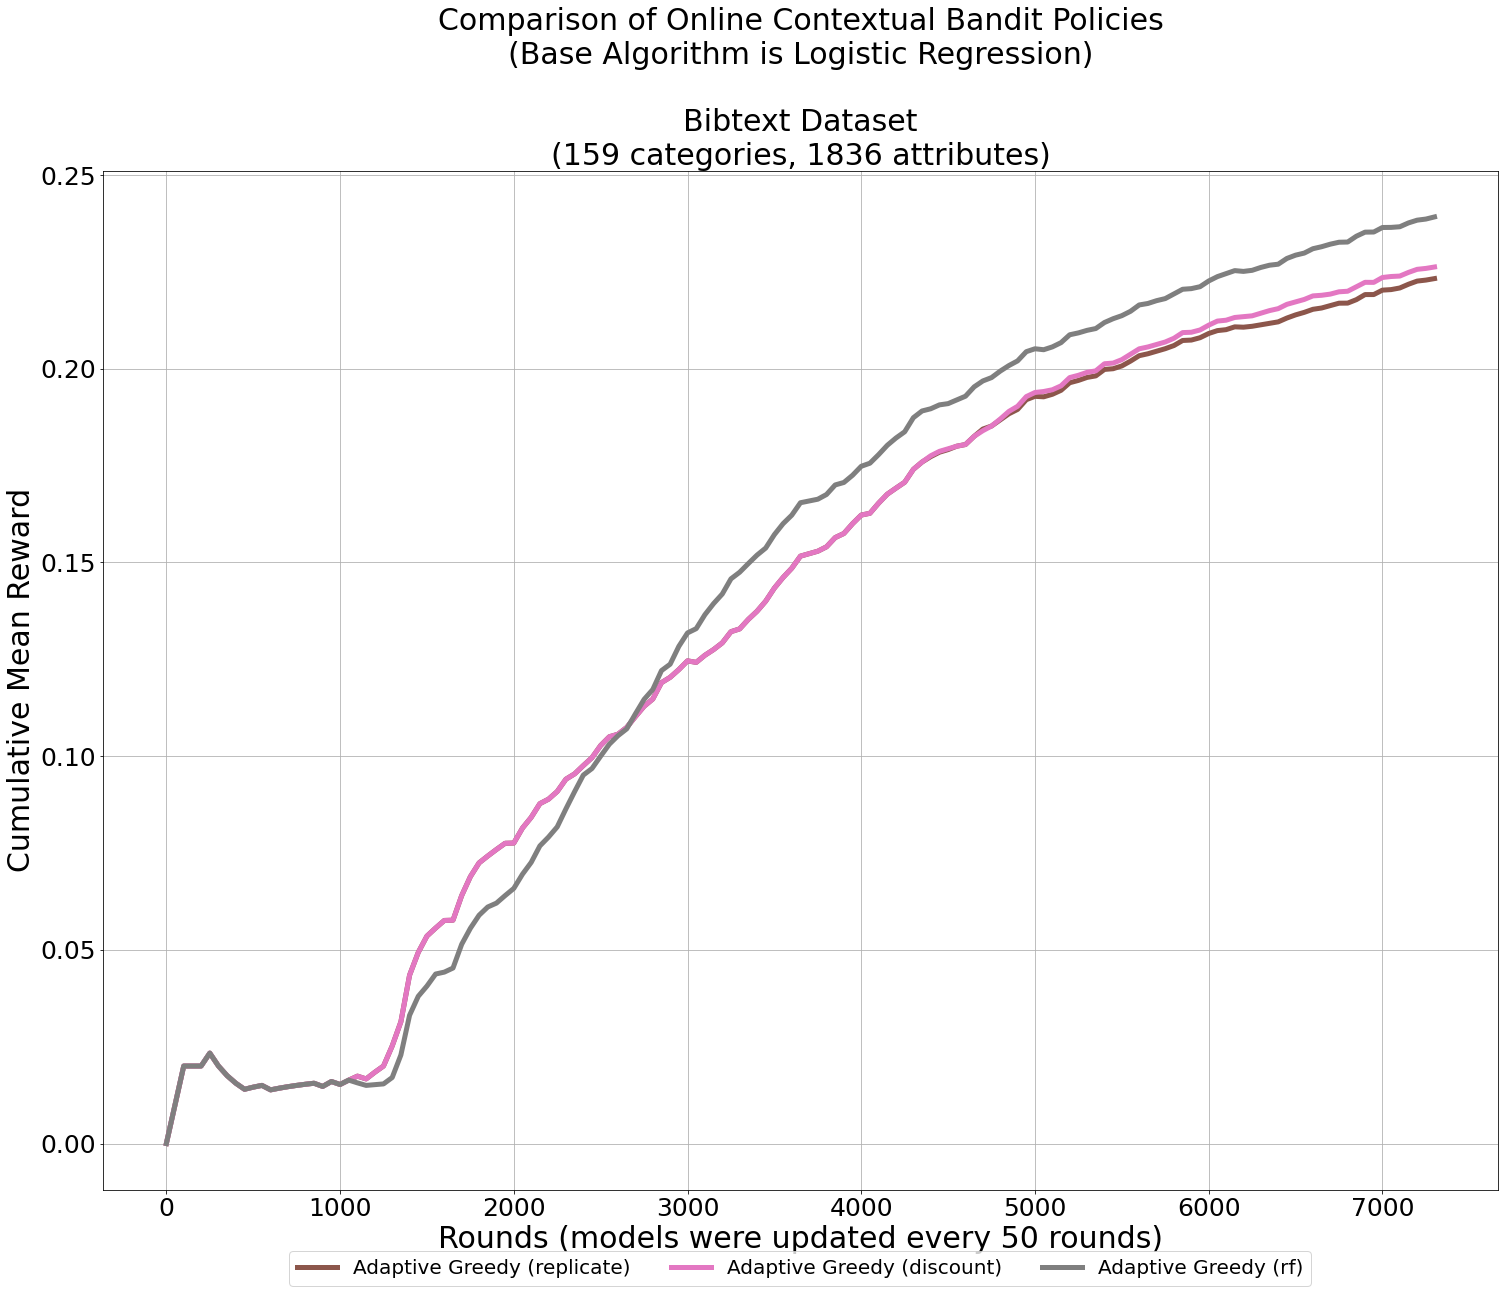

In [9]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (replicate)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (discount)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_agr3), label="Adaptive Greedy (rf)",linewidth=lwd,color=colors[14])

# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()